# COMP 551 Mini Project #1: Machine Learning 101

In [1]:
import json
import project_utilities as utils
from project_utilities import pd, np

import seaborn as sns
import matplotlib.pyplot as plt

with open('proj1_data.json') as fp:
    data = json.load(fp)

## Task 1: Construct the Dataset and Extract Features

In [2]:
X = utils.process_data(data)

### Split Data into Training, Validation, and Test Sets

In [3]:
X_train = X[0:10000]
X_validation = X[10000:11000]
X_test = X[11000:]

assert len(X_train) == 10000 , 'Expected 10000. Got %d' % len(X_train)
assert len(X_validation) == 1000 , 'Expected 1000. Got %d' % len(X_validation)
assert len(X_test) == 1000 , 'Expected 1000. Got %d' % len(X_test)

### Word Count Features

In [4]:
top_words_train = utils.get_top_words(X_train)
assert len(top_words_train) == 160, 'Expected 160. Got %d' % len(top_words_train)

X_train = utils.insert_top_words_count(X_train, top_words_train)
X_validation = utils.insert_top_words_count(X_validation, top_words_train)
X_test = utils.insert_top_words_count(X_test, top_words_train)

In [5]:
with open('words.txt', 'w') as fd:
    fd.write(' '.join(top_words_train))

### Convert to Pandas Dataframe for Ease of Handling

In [6]:
X_train = pd.DataFrame(X_train)
X_validation = pd.DataFrame(X_validation)
X_test = pd.DataFrame(X_test)

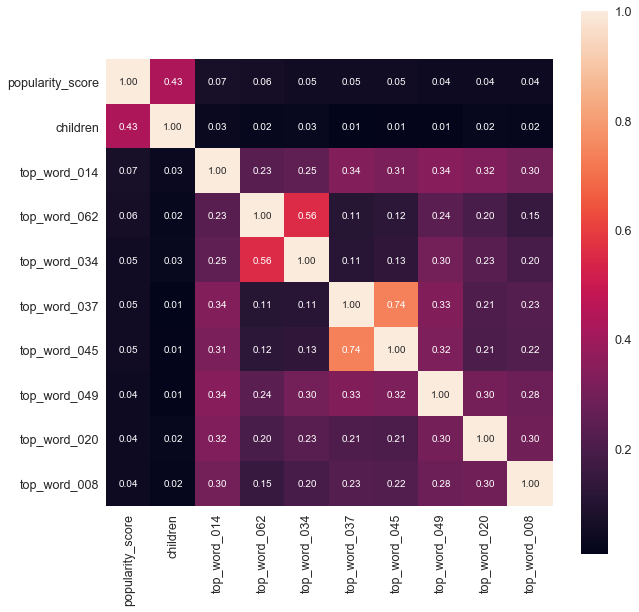

In [7]:
nb_top_corr = 10
cols = X_train.corr().nlargest(nb_top_corr, 'popularity_score')['popularity_score'].index
cm = np.corrcoef(X_train[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(10,10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show();

We can already get a sense of which features we should consider when training our models to predict a comment's popularity score. Unfortunately, it looks as if the children feature is one of the only at-least-mildly correlated features with popularity score.

### New Features
New Feature #1: Children ^ 2<br>
New Feature #2: Children ^ 3<br>
__Note:__ The has_exclamation feature was included in the data processing step.

In [8]:
X_train['children_squared'] = X_train['children']**2
X_validation['children_squared'] = X_validation['children']**2
X_test['children_squared'] = X_test['children']**2

X_train['children_cubed'] = X_train['children']**3
X_validation['children_cubed'] = X_validation['children']**3
X_test['children_cubed'] = X_test['children']**3

In [9]:
X_train[['children_squared', 'children_cubed']].describe()

,children_squared,children_cubed
count,10000.000000,10000.000000
mean,1.960800,38.140000
std,34.018686,1215.634661
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,1849.000000,79507.000000


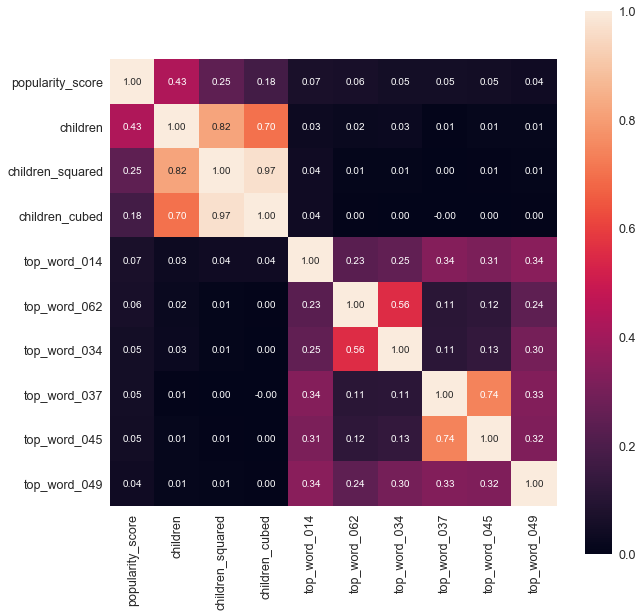

In [10]:
nb_top_corr = 10
cols = X_train.corr().nlargest(nb_top_corr, 'popularity_score')['popularity_score'].index
cm = np.corrcoef(X_train[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(10,10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show();

Here we can notice that our two new features are weakly correlated with popularity score. However, we'll still experiment with these two new features and determine their effects on our prediction accuracy. We should also note that the features children-squared and children-cubed are very strongly correlated to one another. So even if one of the two features improves the MSE of our models, it would be suprising to see that incorporating both of the new features in our model would improve MSE significantly more than just the incorporation of one of the two features.

## Task 2: Implement Linear Regression

A bias must be included. We will also run experiments to predict the popularity score of reddit comments. Therefore, we have remove that feature from our dataset as well.

In [11]:
X_train['bias'] = pd.Series(np.ones(X_train.shape[0]), index=X_train.index)
X_validation['bias'] = pd.Series(np.ones(X_validation.shape[0]), index=X_validation.index)
X_test['bias'] = pd.Series(np.ones(X_test.shape[0]), index=X_test.index)

y_train = X_train['popularity_score']
y_validation = X_validation['popularity_score']
y_test = X_test['popularity_score']

X_train.drop(columns=['text', 'popularity_score'], inplace=True)
X_validation.drop(columns=['text', 'popularity_score'], inplace=True)
X_test.drop(columns=['text', 'popularity_score'], inplace=True)

### 1. Using the Closed Form Solution

In [12]:
utils.LinearRegressionModel().fit_closed_form(X_train.values, y_train.values);

Time Elapsed: 0.006982 seconds


### 2. Using Gradient Descent

In [13]:
utils.LinearRegressionModel().fit_gradient_descent(X_train.values, y_train.values, step_size=0.00000001, decay_factor=10, error_threshold=0.0001);

Time Elapsed: 0.004988 seconds


__Note:__ The actual implementations of the closed-form solution approach and the gradient descent approach can be viewed within the *project_utilities.py* file.

## Task 3: Run Experiments

### 1. Compare the runtime, stability, and performance of the closed-form linear regression and gradient descent approaches.
__Note:__ For this substask, the models will train and predict using the 3 simple features provided.

In [14]:
X_train_compare = X_train[['children', 'controversiality', 'is_root']]
X_validation_compare = X_validation[['children', 'controversiality', 'is_root']]

#### i) Closed Form Solution Runtime, Stability, and Performance

##### a. Training with the Whole Training Dataset

In [15]:
model_cf = utils.LinearRegressionModel().fit_closed_form(X_train_compare.values, y_train.values)

print('MSE: %f' % (utils.mse(y_validation.values, model_cf.predict(X_validation_compare.values))))

Time Elapsed: 0.000000 seconds
MSE: 1.416295


##### b. Training with 25% Partitions of Training Dataset

In [16]:
model_cf_25_1 = utils.LinearRegressionModel().fit_closed_form(X_train_compare[:250].values, y_train[:250].values)
model_cf_25_2 = utils.LinearRegressionModel().fit_closed_form(X_train_compare[250:500].values, y_train[250:500].values)
model_cf_25_3 = utils.LinearRegressionModel().fit_closed_form(X_train_compare[500:750].values, y_train[500:750].values)
model_cf_25_4 = utils.LinearRegressionModel().fit_closed_form(X_train_compare[750:].values, y_train[750:].values)

print('MSE: %f' % (utils.mse(y_validation.values, model_cf_25_1.predict(X_validation_compare.values))))
print('MSE: %f' % (utils.mse(y_validation.values, model_cf_25_2.predict(X_validation_compare.values))))
print('MSE: %f' % (utils.mse(y_validation.values, model_cf_25_3.predict(X_validation_compare.values))))
print('MSE: %f' % (utils.mse(y_validation.values, model_cf_25_4.predict(X_validation_compare.values))))

Time Elapsed: 0.000000 seconds
Time Elapsed: 0.000000 seconds
Time Elapsed: 0.000000 seconds
Time Elapsed: 0.000997 seconds
MSE: 1.693259
MSE: 1.427936
MSE: 1.473821
MSE: 1.417567


##### c. Training with 50% Partitions of Training Dataset

In [17]:
model_cf_50_1 = utils.LinearRegressionModel().fit_closed_form(X_train_compare[:500].values, y_train[:500].values)
model_cf_50_2 = utils.LinearRegressionModel().fit_closed_form(X_train_compare[500:].values, y_train[500:].values)

print('MSE: %f' % (utils.mse(y_validation.values, model_cf_50_1.predict(X_validation_compare.values))))
print('MSE: %f' % (utils.mse(y_validation.values, model_cf_50_2.predict(X_validation_compare.values))))

Time Elapsed: 0.000000 seconds
Time Elapsed: 0.000000 seconds
MSE: 1.421250
MSE: 1.416218


#### ii) Gradient Descent Runtime, Stability, and Performance

##### a. (Initial Step Size = 0.001, Decay Factor = 10, Error Threshold = 0.0001)

In [18]:
model_gd = utils.LinearRegressionModel().fit_gradient_descent(X_train_compare.values, y_train.values, step_size=0.001, decay_factor=10, error_threshold=0.0001)

print('MSE: %f' % (utils.mse(y_validation.values, model_gd.predict(X_validation_compare.values))))

Time Elapsed: 0.005984 seconds
MSE: 1.435591


##### b. (Initial Step Size = 0.00001, Decay Factor = 10, Error Threshold = 0.0001)

In [19]:
model_gradient_descent_1 = utils.LinearRegressionModel().fit_gradient_descent(X_train_compare.values, y_train.values, step_size=0.00001, decay_factor=10, error_threshold=0.0001)

print('MSE: %f' % (utils.mse(y_validation.values, model_gradient_descent_1.predict(X_validation_compare.values))))

Time Elapsed: 0.003995 seconds
MSE: 1.937220


##### c. (Initial Step Size = 0.001, Decay Factor = 5, Error Threshold = 0.0001)

In [20]:
model_gradient_descent_2 = utils.LinearRegressionModel().fit_gradient_descent(X_train_compare.values, y_train.values, step_size=0.001, decay_factor=5, error_threshold=0.0001)

print('MSE: %f' % (utils.mse(y_validation.values, model_gradient_descent_2.predict(X_validation_compare.values))))

Time Elapsed: 0.007979 seconds
MSE: 1.430775


##### d. (Initial Step Size = 0.001, Decay Factor = 10, Error Threshold = 0.000001)

In [21]:
model_gradient_descent_3 = utils.LinearRegressionModel().fit_gradient_descent(X_train_compare.values, y_train.values, step_size=0.001, decay_factor=10, error_threshold=0.000001)

print('MSE: %f' % (utils.mse(y_validation.values, model_gradient_descent_3.predict(X_validation_compare.values))))

Time Elapsed: 0.299199 seconds
MSE: 1.432335


##### e. (Initial Step Size = 0.001, Decay Factor = 5, Error Threshold = 0.000001)
This model is trained with a set of parameters that have previously demonstrated (in steps a to d) to lower MSE.

In [22]:
model_gradient_descent_4 = utils.LinearRegressionModel().fit_gradient_descent(X_train_compare.values, y_train.values, step_size=0.001, decay_factor=5, error_threshold=0.000001)

print('MSE: %f' % (utils.mse(y_validation.values, model_gradient_descent_4.predict(X_validation_compare.values))))

Time Elapsed: 0.374017 seconds
MSE: 1.426481


As we can see with the experimentations in steps *a* through *e*, out of all the gradient descent models, the one with the following parameters: Initial Step Size = 0.001, Decay Factor = 5, and Error Threshold = 0.000001 had the best performance. It had an MSE of 1.426481. However, it also had the longest training time.

### 2. Comparison of Models with No Text Features, Top 60 Words, and Full 160 Word Occurrence Features

For the following experiments, we will be using the closed-form approach, due to it's fastest runtime and highest performance as demonstrated in the previous section.

In [23]:
columns = ['children', 'controversiality', 'is_root']
for i in range(1, 61):
    columns.append('top_word_' + str(i).zfill(3))

X_train_60 = X_train[columns]
X_validation_60 = X_validation[columns]

In [24]:
X_train_160 = X_train.drop(columns=['children_squared', 'children_cubed'])
X_validation_160 = X_validation.drop(columns=['children_squared', 'children_cubed'])

#### i) No Text Features

In [25]:
model_cf = utils.LinearRegressionModel().fit_closed_form(X_train_compare.values, y_train.values)
print('MSE: %f' % (utils.mse(y_validation.values, model_cf.predict(X_validation_compare.values))))

Time Elapsed: 0.000998 seconds
MSE: 1.416295


#### ii) Top-60-Words

In [26]:
model_cf_top_60 = utils.LinearRegressionModel().fit_closed_form(X_train_60.values, y_train.values)
print('MSE: %f' % (utils.mse(y_validation.values, model_cf_top_60.predict(X_validation_60.values))))

Time Elapsed: 0.034908 seconds
MSE: 1.355151


#### iii) Top-160-Words

In [27]:
model_cf_top_160 = utils.LinearRegressionModel().fit_closed_form(X_train_160.values, y_train.values)

mse_top_160 = utils.mse(y_validation.values, model_cf_top_160.predict(X_validation_160.values))

print('MSE: %f' % mse_top_160)

Time Elapsed: 0.004989 seconds
MSE: 0.989536


### 3. Demonstrate the Two New Features Improve Performance on the Validation Set

#### i) New Feature #1: Children Squared

In [28]:
X_train_feature_1 = X_train.drop(columns=['children_cubed'])
X_validation_feature_1 = X_validation.drop(columns=['children_cubed'])

In [29]:
model_cf_feature_1 = utils.LinearRegressionModel().fit_closed_form(X_train_feature_1.values, y_train.values)

mse_feature_1 = utils.mse(y_validation.values, model_cf_feature_1.predict(X_validation_feature_1.values))

print('MSE: %f' % mse_feature_1)
print('Improvement in MSE of: %f' % (mse_top_160 - mse_feature_1))

Time Elapsed: 0.008976 seconds
MSE: 0.967395
Improvement in MSE of: 0.022141


#### ii) New Feature #2: Children Cubed

In [30]:
X_train_feature_2 = X_train.drop(columns=['children_squared'])
X_validation_feature_2 = X_validation.drop(columns=['children_squared'])

In [31]:
model_cf_feature_2 = utils.LinearRegressionModel().fit_closed_form(X_train_feature_2.values, y_train.values)

mse_feature_2 = utils.mse(y_validation.values, model_cf_feature_2.predict(X_validation_feature_2.values))

print('MSE: %f' % mse_feature_2)
print('Improvement in MSE of: %f' % (mse_top_160 - mse_feature_2))

Time Elapsed: 0.005989 seconds
MSE: 0.967954
Improvement in MSE of: 0.021582


#### iii) Using Both Features

In [32]:
model_cf_both_features = utils.LinearRegressionModel().fit_closed_form(X_train.values, y_train.values)

mse_both_features = utils.mse(y_validation.values, model_cf_both_features.predict(X_validation.values))

print('MSE: %f' % mse_both_features)
print('Improvement in MSE of: %f' % (mse_top_160 - mse_both_features))

Time Elapsed: 0.005985 seconds
MSE: 0.967704
Improvement in MSE of: 0.021832


We can conclude that the best performing model is the one using the top 160 words with the first new feature: children squared. The model has an MSE of 0.967395

### 4. Run Your Best Model on the Test Set

In [33]:
y_predictions = model_cf_feature_1.predict(X_test.drop(columns=['children_cubed']).values)

print('MSE: %f' % (utils.mse(y_test, y_predictions)))

MSE: 1.292811


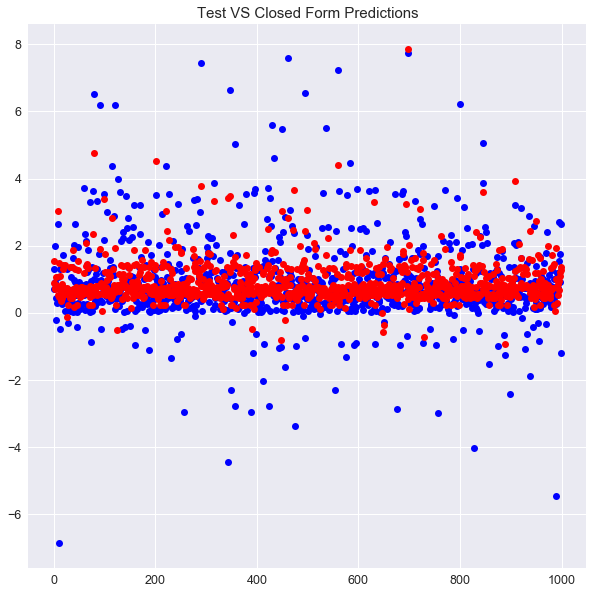

In [34]:
plt.figure(figsize=(10,10))
plt.plot(y_test, "bo", y_predictions, 'ro')
plt.title('Test VS Closed Form Predictions')
plt.show()